In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
# 多行输出
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" 

# Lesson 1 

## 导入包

导入的时候，使用 

1. from fastai import *
2. from fastai.[application_name](https://docs.fast.ai/applications.html) import *

只在使用 fastai 的使用使用 * 导入全部，其他的包，使用什么导入什么

- 目前 fastai支持的四种applications:
    1. Computer vision
    2. Natural language text
    3. Tabular data
    4. Collaborative filtering

In [2]:
from fastai import *
from fastai.vision import *

## 数据集

使用 [Oxford-IIIT Pet Dataset](http://www.robots.ox.ac.uk/~vgg/data/pets/) by [O. M. Parkhi et al., 2012](http://www.robots.ox.ac.uk/~vgg/publications/2012/parkhi12a/parkhi12a.pdf)
这个数据集包括12个猫的品种和25个狗的品种。我们的任务是对这37个品种进行分类。2012年的分类结果为59.21%。
我们使用 `untar_data` 函数，这个函数使用数据集的下载地址 URL 作为参数，这个函数可以下载和解压数据
（原始数据为tgz压缩包）。其返回数据集存储的路径。
为了保证GPU能够有效的并行计算，通常使用同等大小的图片，如 224 x 224

In [3]:
help(untar_data)

Help on function untar_data in module fastai.datasets:

untar_data(url:str, fname:Union[pathlib.Path, str]=None, dest:Union[pathlib.Path, str]=None, data=True, force_download=False) -> pathlib.Path
    Download `url` to `fname` if it doesn't exist, and un-tgz to folder `dest`.



`Union[pathlib.Path, str]` 表示要么是 pathlib.Path，要么是 str

In [4]:
path = untar_data(URLs.PETS) # 下载数据
path # 查看数据存储路径

/home/lab/Softwares/miniconda3/envs/fastai/lib/python3.6/site-packages/fastai/datasets.py:163: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  with open(fpath, 'r') as yaml_file: return yaml.load(yaml_file)


PosixPath('/home/lab/.fastai/data/oxford-iiit-pet')

# 直接下载数据
```bash
$ wget -c https://s3.amazonaws.com/fast-ai-imageclas/oxford-iiit-pet.tgz
```

In [5]:
# 查看路径下的文件
path.ls()

[PosixPath('/home/lab/.fastai/data/oxford-iiit-pet/annotations'),
 PosixPath('/home/lab/.fastai/data/oxford-iiit-pet/images')]

In [6]:
path_anno = path/'annotations'  # 标注文件夹
path_img = path/'images'  # 图片存储文件夹

In [7]:
help(get_image_files)

Help on function get_image_files in module fastai.vision.data:

get_image_files(c:Union[pathlib.Path, str], check_ext:bool=True, recurse=False) -> Collection[pathlib.Path]
    Return list of files in `c` that are images. `check_ext` will filter to `image_extensions`.



`get_image_files` 函数获取路径 c 下的所有图片数据，并返回一个图片文件名/路径的列表

In [8]:
fnames = get_image_files(path_img)
fnames[:5]

[PosixPath('/home/lab/.fastai/data/oxford-iiit-pet/images/chihuahua_54.jpg'),
 PosixPath('/home/lab/.fastai/data/oxford-iiit-pet/images/saint_bernard_172.jpg'),
 PosixPath('/home/lab/.fastai/data/oxford-iiit-pet/images/american_bulldog_153.jpg'),
 PosixPath('/home/lab/.fastai/data/oxford-iiit-pet/images/Egyptian_Mau_74.jpg'),
 PosixPath('/home/lab/.fastai/data/oxford-iiit-pet/images/pomeranian_187.jpg')]

注意这里有个坑，Windows 使用 `\` 作为路径分割符，所以使用 `\\` 代表真正的 `\` (`\`为转义符号)

但这一个问题已经在 1.0.49 中得到修复, 也就是可以使用 `/` 代表路径分隔符和操作系统无关

In [9]:
np.random.seed(2)  # 设置随机状态
pat = r'/([^/]+)_\d+.jpg$'  # 设置正则匹配模式
# pat = r'\\([^\\]+)_\d+.jpg$'  # 设置正则匹配模式 windows 格式
# 上述匹配模式的含义 以/开头，内容不含/的一个或者多个字符紧跟着是_然后是1个或多个数字以.jpg结尾，提取的信息是不含/的字符串
# import re
# x = 'E:/.fastai/data/oxford-iiit-pet/images/Abyssinian_102.jpg'
# match = re.search(pat, x)  # 匹配结果 /Abyssinian_102.jpg
# match.group(1)  # 提取的信息 Abyssinian

- **！坑！** 在 Windows上创建数据集的时候一定要设置 num_workers=0, 否则会报错 `[Errno 32] Broken pipe` 
- 无论使用 PyTorch 或者 fastai 都这样做

In [10]:
bs = 64  # batchsize
# 通过正则匹配来创建数据集
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(), 
                                   size=224, bs=bs)  # Linux
# data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(), 
#                                    size=224, bs=bs, num_workers=0)  # Windows
data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList (5912 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
chihuahua,saint_bernard,american_bulldog,samoyed,scottish_terrier
Path: /home/lab/.fastai/data/oxford-iiit-pet/images;

Valid: LabelList (1478 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
saint_bernard,Bengal,scottish_terrier,american_bulldog,pug
Path: /home/lab/.fastai/data/oxford-iiit-pet/images;

Test: None

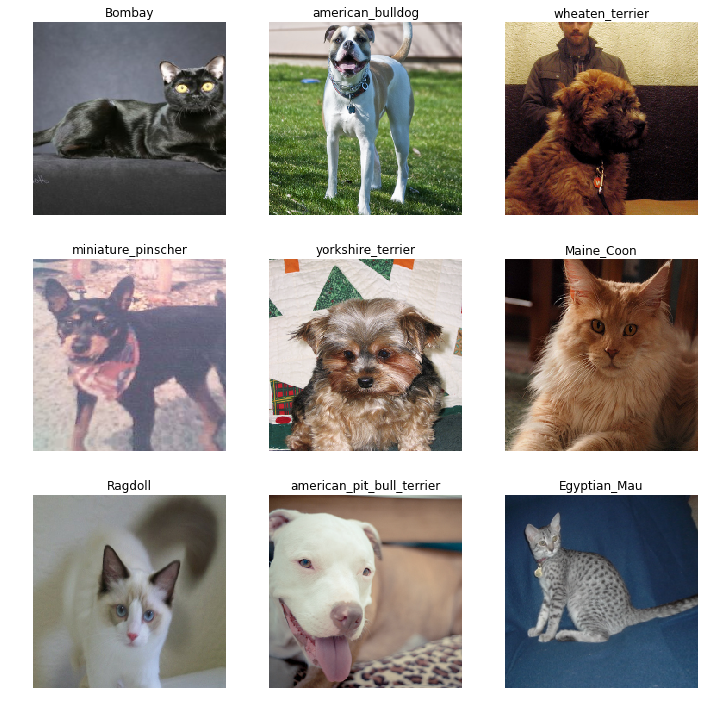

In [12]:
data.show_batch(rows=3, figsize=(10,10))

In [13]:
data.classes  # 数据类
len(data.classes) # 数据类的个数
data.c # 类数

['Abyssinian',
 'Bengal',
 'Birman',
 'Bombay',
 'British_Shorthair',
 'Egyptian_Mau',
 'Maine_Coon',
 'Persian',
 'Ragdoll',
 'Russian_Blue',
 'Siamese',
 'Sphynx',
 'american_bulldog',
 'american_pit_bull_terrier',
 'basset_hound',
 'beagle',
 'boxer',
 'chihuahua',
 'english_cocker_spaniel',
 'english_setter',
 'german_shorthaired',
 'great_pyrenees',
 'havanese',
 'japanese_chin',
 'keeshond',
 'leonberger',
 'miniature_pinscher',
 'newfoundland',
 'pomeranian',
 'pug',
 'saint_bernard',
 'samoyed',
 'scottish_terrier',
 'shiba_inu',
 'staffordshire_bull_terrier',
 'wheaten_terrier',
 'yorkshire_terrier']

37

37

## 训练模型

创建学习器

In [14]:
# 使用 resnet34
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /home/lab/.torch/models/resnet34-333f7ec4.pth
87306240it [00:09, 8865100.83it/s]


In [15]:
# 查看模型
learn

Learner(data=ImageDataBunch;

Train: LabelList (5912 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
chihuahua,saint_bernard,american_bulldog,samoyed,scottish_terrier
Path: /home/lab/.fastai/data/oxford-iiit-pet/images;

Valid: LabelList (1478 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
saint_bernard,Bengal,scottish_terrier,american_bulldog,pug
Path: /home/lab/.fastai/data/oxford-iiit-pet/images;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=

In [16]:
help(learn.fit_one_cycle)

Help on method fit_one_cycle in module fastai.train:

fit_one_cycle(cyc_len:int, max_lr:Union[float, Collection[float], slice]=slice(None, 0.003, None), moms:Tuple[float, float]=(0.95, 0.85), div_factor:float=25.0, pct_start:float=0.3, final_div:float=None, wd:float=None, callbacks:Union[Collection[fastai.callback.Callback], NoneType]=None, tot_epochs:int=None, start_epoch:int=None) -> None method of fastai.basic_train.Learner instance
    Fit a model following the 1cycle policy.



- cyc_len: epoch 数
- max_lr:Union[float, Collection[float], slice]=slice(None, 0.003, None) 学习率，默认为 0.003
- moms:Tuple[float, float]=(0.95, 0.85) 动量设置， 默认为 (0.95, 0.85)

In [17]:
# 使用 one cycle策略进行训练 4 epoch
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.373836,0.363887,0.112314,00:23
1,0.540370,0.286532,0.091340,00:21
2,0.341972,0.237115,0.081191,00:21
3,0.265110,0.229442,0.080514,00:21


* 上述结果表明：使用resnet34预训练模型，经过4个epoch的训练，我们可以得到 0.07 左右的误差率，远远优于2012年的56.21%的分类准确率
* 这个时候训练的只是我们添加到最后的全连接层的权重

In [18]:
# 保存训练的模型
learn.save('stage-1', return_path=True)

PosixPath('/home/lab/.fastai/data/oxford-iiit-pet/images/models/stage-1.pth')

## 结果

1. 查看损失最大的样本

In [19]:
help( ClassificationInterpretation.from_learner)

Help on method _cl_int_from_learner in module fastai.vision.learner:

_cl_int_from_learner(learn:fastai.basic_train.Learner, ds_type:fastai.basic_data.DatasetType=<DatasetType.Valid: 2>, tta=False) method of builtins.type instance
    Create an instance of `ClassificationInterpretation`. `tta` indicates if we want to use Test Time Augmentation.



ClassificationInterpretation: [vision.learner | fastai](https://docs.fast.ai/vision.learner.html#ClassificationInterpretation)

In [20]:
interp = ClassificationInterpretation.from_learner(learn)  # fastai的模型解释器
interp

In [21]:
# 最大的损失，以及它们所在的索引
losses, idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

True

In [22]:
losses, idxs

(tensor([9.2905e+00, 8.6477e+00, 6.5765e+00,  ..., 7.6294e-06, 3.8147e-06,
         1.9073e-06]), tensor([ 279,   13,  902,  ..., 1443,  836,  733]))

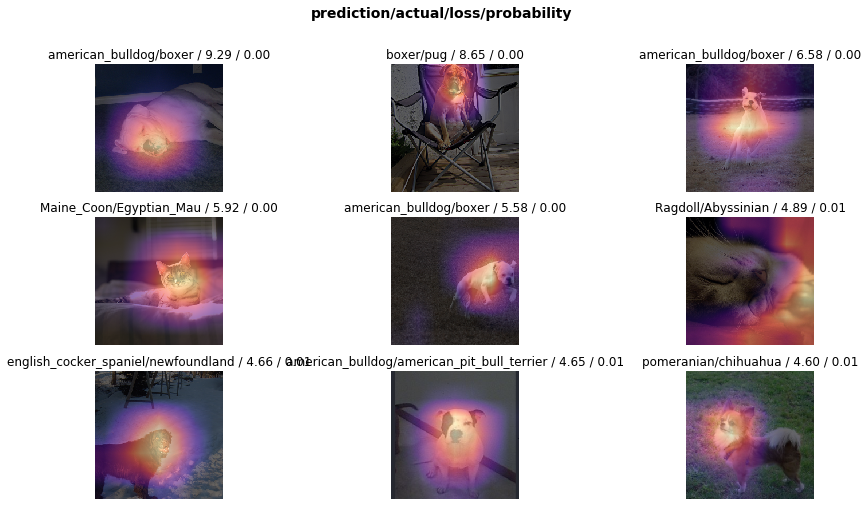

In [23]:
interp.plot_top_losses(9, figsize=(15, 8))

上面的标注依次为： prediction, actual, loss, and probability of predicted class

2. 使用混淆矩阵来评价模型

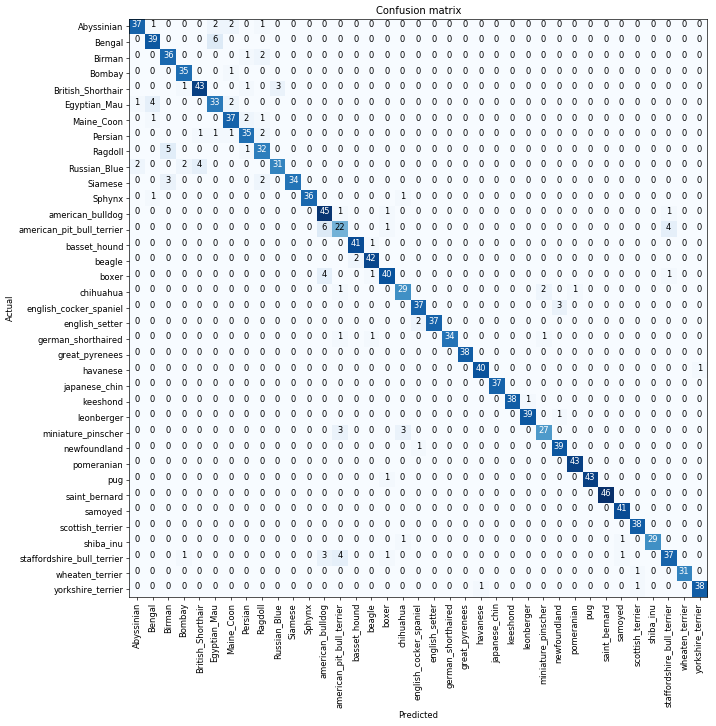

In [24]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

- 我们可以看到分布严重倾斜:模型一再犯同样的错误，但很少混淆其他类别。这表明它只是发现很难区分某些特定类别;这是正常的行为。
- 在类别比较多的时候，可视化混淆矩阵就会变得困难，这个时候使用most_confused函数

In [25]:
# 混乱矩阵中最大的非对角项的降序列表，actual, predicted, number of occurrences
# min_val 表示最小预测错误的次数
interp.most_confused(min_val=2)

[('Bengal', 'Egyptian_Mau', 6),
 ('american_pit_bull_terrier', 'american_bulldog', 6),
 ('Ragdoll', 'Birman', 5),
 ('Egyptian_Mau', 'Bengal', 4),
 ('Russian_Blue', 'British_Shorthair', 4),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 4),
 ('boxer', 'american_bulldog', 4),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 4),
 ('British_Shorthair', 'Russian_Blue', 3),
 ('Siamese', 'Birman', 3),
 ('english_cocker_spaniel', 'newfoundland', 3),
 ('miniature_pinscher', 'american_pit_bull_terrier', 3),
 ('miniature_pinscher', 'chihuahua', 3),
 ('staffordshire_bull_terrier', 'american_bulldog', 3),
 ('Abyssinian', 'Egyptian_Mau', 2),
 ('Abyssinian', 'Maine_Coon', 2),
 ('Birman', 'Ragdoll', 2),
 ('Egyptian_Mau', 'Maine_Coon', 2),
 ('Maine_Coon', 'Persian', 2),
 ('Persian', 'Ragdoll', 2),
 ('Russian_Blue', 'Abyssinian', 2),
 ('Russian_Blue', 'Bombay', 2),
 ('Siamese', 'Ragdoll', 2),
 ('beagle', 'basset_hound', 2),
 ('chihuahua', 'miniature_pinscher', 2),
 ('english_se

## 微调学习率

- 通过对不同的layers使用不同的学习率，一般前面的layers学习率小，表示对权重的调整不大，后面的layer学习率大，表示对权重的调整程度较高。
- 首先，需要learn.unfreeze()，使得各个layer的权重是可调整的

In [26]:
learn.unfreeze()

* 使用 0.03 的初始学习率对各层的权重进行适应性调整

In [27]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.515053,0.334538,0.103518,00:27


这里我们会发现在对各层的权重做了调整之后，误差率增大了，也就是说对各层使用同一学习率，一视同仁是不合适的

- 通过[LNCS 8689 - Visualizing and Understanding Convolutional Networks](https://cs.nyu.edu/~fergus/papers/zeilerECCV2014.pdf)来解释为什么，上述训练的结果变差了，前面的layer是学习图像的简单特征，比如角，线等，后面的layer学习的是前面的简单特征的组合，所以一开始我们只训练最后的layer，而不改变前面的layer，这使得我们的模型拥有较低的误差率。但是当我们使用同样的学习率来调整所有layer的权重的时候，反而会使得前面layer的简单特征遭到破坏，因此训练效果也会相应的变差。
* 所以，我们不可以使用上述的训练方式对模型进行训练

In [28]:
# 加载回原来的微调模型状态
learn.load('stage-1')

Learner(data=ImageDataBunch;

Train: LabelList (5912 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
chihuahua,saint_bernard,american_bulldog,samoyed,scottish_terrier
Path: /home/lab/.fastai/data/oxford-iiit-pet/images;

Valid: LabelList (1478 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
saint_bernard,Bengal,scottish_terrier,american_bulldog,pug
Path: /home/lab/.fastai/data/oxford-iiit-pet/images;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=

- 使用 `lr_find()` 函数，查找最优的学习率
- `recorder.plot()` 会绘制 loss-lr 的图，从中我们可以获取学习率的一个范围

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


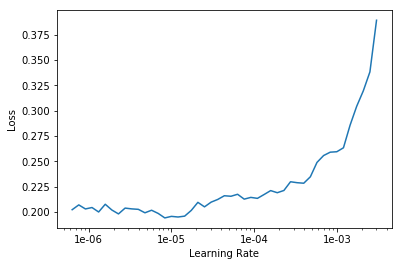

In [29]:
learn.lr_find()
learn.recorder.plot()

- 学习率可以简单地理解为更新模型中的参数的速度有多快。
- 从上述的图中，可以看出，一旦学习率超过 1e-4 损失就会迅速增加，所以，我们的学习率不应该超过1e-4
- `max_lr=slice(1e-6,1e-4)` 表示在开头的layer使用 1e-6 的学习率，在最后的layer使用 1e-4 的学习率。中间的layer的学习率处于二者之间均匀分布
- 一般 max_lr 的最大学习率是第一阶段（只训练最后layer）的 1/10

In [30]:
learn.unfreeze()  # 训练所有的层
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.215516,0.221106,0.071719,00:27
1,0.214965,0.218767,0.072395,00:27


- 这次的误差率在 0.06 左右，比第一个阶段的要稍微好一些

In [31]:
# 最终，保存训练好的模型
learn.save('stage-2')

## 使用 resnet50

- 网络层数变多，也意味着模型的复杂度变高，也会有更多的权重需要学习
- 为了使得内存不溢出，我们也要使用更小的 batchsize
- 这里展示完整的学习过程

### step1 创建数据

In [32]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(), 
                                   size=224, bs=bs//2, num_workers=0)  # Windows
# data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(), 
#                                    size=224, bs=bs//2)  # Linux
data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList (5912 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
chihuahua,saint_bernard,american_bulldog,Egyptian_Mau,samoyed
Path: /home/lab/.fastai/data/oxford-iiit-pet/images;

Valid: LabelList (1478 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
wheaten_terrier,american_bulldog,Bombay,american_pit_bull_terrier,Ragdoll
Path: /home/lab/.fastai/data/oxford-iiit-pet/images;

Test: None

In [33]:
imagenet_stats  # imagenet 图片的均值、标准差

([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

### step2 创建学习器

In [35]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

### stage 1：对最后的layer进行权重学习

In [36]:
learn.fit_one_cycle(8)

epoch,train_loss,valid_loss,error_rate,time
0,0.686929,0.319312,0.090663,01:24
1,0.442860,0.290966,0.087280,01:22
2,0.352472,0.267100,0.088633,01:22
3,0.313167,0.232841,0.077131,01:22
4,0.248410,0.205715,0.064276,01:22
5,0.175112,0.199757,0.062246,01:22
6,0.133887,0.185776,0.058863,01:22
7,0.121582,0.180216,0.054804,01:22


In [37]:
learn.save('stage-1-50')

### stage2：对所有layer的权重进行微调

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


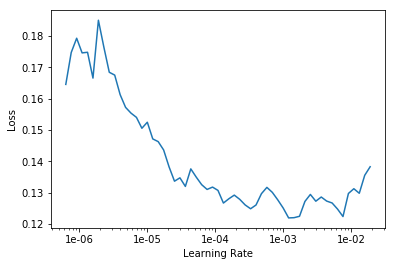

In [38]:
# 寻找最优unfreezeeezefreezefreeze率
learn.lr_find()
learn.recorder.plot()

In [39]:
# 微调权重
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.125962,0.169336,0.058187,01:36
1,0.106010,0.172793,0.053451,01:35
2,0.099089,0.176399,0.054804,01:35


In [40]:
learn.save('stage-2-50')

* 最后我们选择的模型是 stage1 或者 stage2 中的一个，具体取决于模型的效果

### 解释模型

In [41]:
# 导入模型并分析训练结果
learn.load('stage-2-50')
interp = ClassificationInterpretation.from_learner(learn)

In [42]:
interp.most_confused(min_val=2)

[('american_pit_bull_terrier', 'staffordshire_bull_terrier', 8),
 ('Ragdoll', 'Birman', 5),
 ('boxer', 'american_bulldog', 4),
 ('Ragdoll', 'Persian', 3),
 ('Bengal', 'Egyptian_Mau', 2),
 ('Egyptian_Mau', 'Bengal', 2),
 ('Maine_Coon', 'Bengal', 2),
 ('beagle', 'american_bulldog', 2),
 ('chihuahua', 'miniature_pinscher', 2),
 ('english_cocker_spaniel', 'english_setter', 2),
 ('english_cocker_spaniel', 'german_shorthaired', 2),
 ('miniature_pinscher', 'american_pit_bull_terrier', 2),
 ('pomeranian', 'samoyed', 2),
 ('saint_bernard', 'newfoundland', 2),
 ('yorkshire_terrier', 'havanese', 2)]

## MNIST 数据集

In [44]:
# 获取数据
path = untar_data(URLs.MNIST_SAMPLE)

/home/lab/Softwares/miniconda3/envs/fastai/lib/python3.6/site-packages/fastai/datasets.py:163: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  with open(fpath, 'r') as yaml_file: return yaml.load(yaml_file)


In [45]:
tfms = get_transforms(do_flip=False)  # 不对图片进行随机翻转，默认情况下会对图片进行随机翻转
# 使用 from_folder 的方式创建数据
data = ImageDataBunch.from_folder(path, ds_tfms=tfms, size=26, num_workers=0)  # 只有训练集验证集的数据，没有标签

In [46]:
data # 此时的CategoryList是具体的类名

ImageDataBunch;

Train: LabelList (12396 items)
x: ImageList
Image (3, 26, 26),Image (3, 26, 26),Image (3, 26, 26),Image (3, 26, 26),Image (3, 26, 26)
y: CategoryList
3,3,3,3,3
Path: /home/lab/.fastai/data/mnist_sample;

Valid: LabelList (2038 items)
x: ImageList
Image (3, 26, 26),Image (3, 26, 26),Image (3, 26, 26),Image (3, 26, 26),Image (3, 26, 26)
y: CategoryList
3,3,3,3,3
Path: /home/lab/.fastai/data/mnist_sample;

Test: None

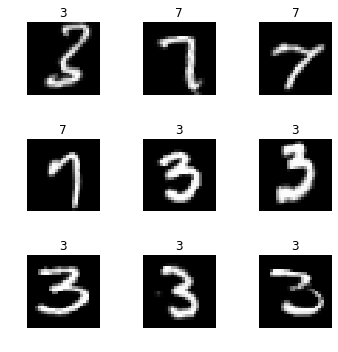

In [47]:
# 查看部分数据
data.show_batch(rows=3, figsize=(5,5))

In [48]:
# 创建学习器 resnet18，使用 精确度 作为评价标准
learn = cnn_learner(data, models.resnet18, metrics=accuracy)
learn.fit(2)  # stage1 训练 2 epoch

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /home/lab/.torch/models/resnet18-5c106cde.pth
46827520it [00:05, 8467406.97it/s]


epoch,train_loss,valid_loss,accuracy,time
0,0.164152,0.081055,0.969578,00:15
1,0.084174,0.046135,0.982336,00:14


In [49]:
# 读入标签
df = pd.read_csv(path/'labels.csv')
df.head()

,name,label
0,train/3/7463.png,0
1,train/3/21102.png,0
2,train/3/31559.png,0
3,train/3/46882.png,0
4,train/3/26209.png,0


In [50]:
data = ImageDataBunch.from_csv(path, ds_tfms=tfms, size=28, num_workers=0) # 添加标签的同时一并改变图片的大小
data  # 此时的CategoryList是经过处理的类名

ImageDataBunch;

Train: LabelList (11548 items)
x: ImageList
Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28)
y: CategoryList
0,0,0,0,0
Path: /home/lab/.fastai/data/mnist_sample;

Valid: LabelList (2886 items)
x: ImageList
Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28)
y: CategoryList
0,0,1,0,0
Path: /home/lab/.fastai/data/mnist_sample;

Test: None

[0, 1]

2

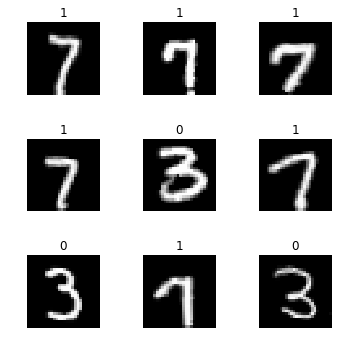

In [51]:
# 再次查看图片
data.show_batch(rows=3, figsize=(5,5))
data.classes  # 类别对应的标注 (0, 1)
data.c

In [52]:
# 获取文件名的列表
fn_paths = [path/name for name in df['name']]
fn_paths[:2]

[PosixPath('/home/lab/.fastai/data/mnist_sample/train/3/7463.png'),
 PosixPath('/home/lab/.fastai/data/mnist_sample/train/3/21102.png')]

In [53]:
pat = r"/(\d)/\d+\.png$"
data = ImageDataBunch.from_name_re(path, fn_paths, pat=pat, ds_tfms=tfms, size=24, num_workers=0)
data.classes  # 类别对应的名称

['3', '7']

In [54]:
# 获取类别名称的另外一种方法
data = ImageDataBunch.from_name_func(path, fn_paths, ds_tfms=tfms, size=24,num_workers=0,
        label_func = lambda x: '3' if '/3/' in str(x) else '7')
data.classes

['3', '7']

In [55]:
# 获取对应的标签
labels = [('3' if '/3/' in str(x) else '7') for x in fn_paths]
labels[:5]

['3', '3', '3', '3', '3']

In [56]:
# 获取类别名称的另外一种方法
data = ImageDataBunch.from_lists(path, fn_paths, labels=labels, ds_tfms=tfms, size=24, num_workers=0)
data.classes

['3', '7']

In [57]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


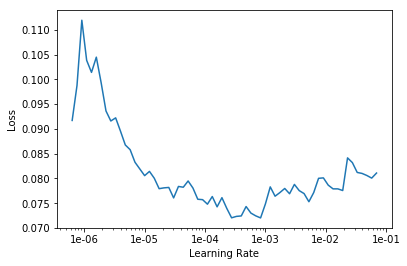

In [58]:
learn.recorder.plot()

In [59]:
learn.unfreeze()
learn.fit_one_cycle(8, max_lr=slice(5e-6, 1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.068159,0.030380,0.989205,00:15
1,0.041009,0.017050,0.995093,00:15
2,0.029644,0.013123,0.995093,00:16
3,0.017703,0.009831,0.997056,00:16
4,0.016657,0.009742,0.997056,00:16
5,0.008405,0.007161,0.996565,00:16
6,0.006920,0.006249,0.998037,00:16
7,0.005736,0.006099,0.997547,00:16
